In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import pandas as pd
import scipy.optimize as opt
import scipy.special as sf #Needed for paramater fitting

In [2]:
def Offsetter(Row, xoffset):
    newRow = np.zeros(np.size(Row) - xoffset)
    newRow = Row[xoffset::]

#Not sure where to put offsetter for minimum calls
    
def Freqmaker(Row):
    N = np.size(Row)
    f = np.fft.fftfreq(N)
    return f
 
#There is a scipy function that does convolutions but I can do it by hand and I don't want to import too many libraries
#Note: Think about adapting this so that the smoothing is only at the top, probably need to provide a signal height
def Smoothing(Row, sigma): #This is really a NoiseRemover but its more generally useful also
    N = np.size(Row)
    tt = np.arange(-N/2, N/2)
    Rowft = np.fft.fft(Row)
    #Make a Gaussian to try to smooth this out, we don't care about super high freq signals theyre just noise
    G =np.fft.fft(np.exp(-tt ** 2 / (2 * sigma ** 2)) / np.sqrt(2 * np.pi) / sigma)
    conv1 = Rowft * G
    smoothRow = np.fft.ifft(conv1)
    return smoothRow

  
def NoiseRemoverv1(NotchRow):
    #Probably need to scale notNotchRow as Notch row has lower amp
    SimpRow = np.zeros_like(NotchRow)
    for index in range(np.size(NotchRow)):
        if (NotchRow[index] >= np.mean(NotchRow)):
            SimpRow[index] = np.mean(NotchRow)
        else :
            SimpRow[index] = NotchRow[index]
    return SimpRow

def NoiseRemover2(Row, limit): #Simple Low Pass Filter, could work in addittion to 1
    f = Freqmaker(Row)
    Rowft = np.fft.fft(Row)
    Rowft2 = Rowft.copy()
    Rowft2[np.abs(f) > limit] = 0
    Final = np.fft.ifft(Rowft2)
    return Final

def NoiseRemover3(notNotchRow, NotchRow):
    NotchRow2 = NotchRow.copy()
    for i in range(len(NotchRow)):
        NotchRow2[i] = NotchRow[i] - notNotchRow[i] + np.mean(NotchRow)
    return NotchRow2

#Once I pick one of the above methods that works best for removing the curves and leaving me with just notches to analyze
#I then need to look at notch movement... Just compare corners ?

#Could pick out corners using a similar method as above with square wave, but these should probably be standardized
def NotchMove(NotchRow, Cornerlocs, StandNotchRow):
    Cornervals = np.array([])
    for i in range(len(Cornerlocs)):
        Cornervals.append(StandNotchRow[Cornerlocs[i]] - NotchRow[Cornerlocs[i]])
    average = np.mean(Cornervals)
    return average

#Going to try yet another totally different approach with parameter fitting

#This will be normalized to one but can be adjusted for Notch Height, Idk height and maybe length
#def y_model()
#This code also needs to only fit some parts of the row where the notches are, might try to fit hi/lo wave with simular code

def Notchfinder(NotchRow, height):
    justNotch = np.array([])
    for i in range(len(NotchRow)):
        if (NotchRow[ind] <= height):
            justNotch.append(NotchRow[ind])
    return justNotch

def NotchLength(NotchRow, height):
    NotchLenList = np.array([])
    counter = 0
    for i in len(NotchRow):
        if (NotchRow[ind] <= height):
            counter = counter + 1
        else:
            NotchLenList.append(counter)
            counter = 0
    return NotchLenList
    
    
#Square waves go up and down not just down, so to cause this make every other notch flip up
def makeItSquare(justNotch, NotchLenList):
    sign = 1
    counter = 0
    counter2 = 0
    for i in range(len(justNotch)):
        if(counter < NotchLenList[counter2]):
            justNotch[i] = justNotch[i] * sign
            counter = counter + 1
        else:
            sign = sign * -1
            counter = 0
            counter2 = counter2 + 1
        return justNotch

    
def DomFreqFinder(Row, peak): #Just using this to make sure the right freq can be found before/after noise
    N= np.size(Row)
    Rowft = np.fft.fft(Row) 
    f = Freqmaker(Row)
    #fft freq has 0 then pos then neg in reverse order so these need to be ordered properly
    index = np.arange(1, N//2 + 1) # // casts integer division
    psd = np.abs(Rowft[index] ** 2 + np.abs(Rowft[-index]) ** 2)
    #plt.plot(f, psd, 'k-')
    ImpFreq = f[index[np.where(psd > peak)]]
    print ('Most Contributing Frequencies:', ImpFreq)
    return psd

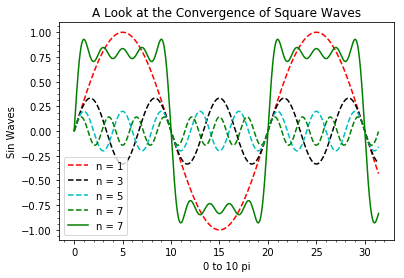

In [3]:
def nsin(n, L, x):
    return 1/ n * np.sin(n * np.pi * x / L)

xrange = np.linspace(0, 10 * np.pi, 1000)

sume = np.zeros_like(xrange)
for n in range(5):
    sume = sume + nsin(2 * n + 1, 10, xrange)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xrange, nsin(1, 10, xrange), 'r--', label = 'n = 1')
ax.plot(xrange, nsin(3, 10, xrange), 'k--', label = 'n = 3')
ax.plot(xrange, nsin(5, 10, xrange), 'c--', label = 'n = 5')
ax.plot(xrange, nsin(7, 10, xrange), 'g--', label = 'n = 7')
ax.plot(xrange, sume, 'g-', label = 'n = 7')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('0 to 10 pi')
ax.set_ylabel('Sin Waves')
ax.set_title('A Look at the Convergence of Square Waves')


#x is pixels in this case, this is the function to fit to
def squarewave(x, a1, a2, a3, a4, a5, a6):
    return ((1/a1)*np.sin(a1*x*np.pi * 1/10 +a6) + (1/a2)*np.sin(a2*x*np.pi * 1/10 +a6) + (1/a3)*np.sin(a3*x*np.pi *1/10 +a6) + (1/a4)*np.sin(a4*x*np.pi *1/10 +a6)) + a5


def paramfitcheck(x, y, unc):
    (p, C) = opt.curve_fit(squarewave, x, y, p0 = [1, 3, 5, 7, 2800, 0])
    sigma_p = np.sqrt(np.diag(C))
    chisq = np.sum(y - squarewave(x, *p))**2 / unc ** 2
    dof = len(y) - len(p)
    Q = sf.gammaincc(dof/2, chisq/2)
    
    #if L is decided by pixel offset remember to fix here
    print ("""Fit Performed:
    a1 = {} +/- {}
    a2 = {} +/- {}
    a3 = {} +/- {}
    a4 = {} +/- {}       
    a5 = {} +/- {}
    a6 = {} +/- {}
    chisq = {}
    normchisq = {}
    dof = {}
    goodness of fit = {}""".format(p[0], sigma_p[0], p[1], sigma_p[1], p[2], sigma_p[2], p[3], sigma_p[3], p[4], sigma_p[4], p[5], sigma_p[5],
                                  chisq, chisq/dof, dof, Q))
    
           
                  
    return p, sigma_p, chisq, dof, Q



In [18]:
#This will perform/return all noise removal strategies and graph them all out on top of eachother
def Comparison(notNotchRow, NotchRow, limit, sigma):
    attempt = NoiseRemoverv1(NotchRow)
    Lowpass = np.abs(NoiseRemover2(NotchRow, limit))
    Smooth = np.abs(Smoothing(NotchRow, sigma))
    Negative = NoiseRemover3(notNotchRow, NotchRow)
    NegandAtt = NoiseRemoverv1(NotchRow)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_size_inches(15, 8)
    x = np.linspace(0, np.size(NotchRow), np.size(NotchRow))
    ax.plot(x, NotchRow, 'g--', label = 'Original Data')
    #ax.plot(x, attempt, 'r-', ms = 3, label = 'Mean Collection')
    #ax.plot(x, Lowpass, 'k-', lw = 1.5, label = 'Lowpass')
    #ax.plot(x, Smooth, 'k-', ms = 3, label = 'Smoothing')
    #ax.plot(x, Negative, 'k-', ms = 3, label = 'Cancelled Rows')
    #ax.plot(x, NegandAtt, 'm-', ms = 3, label = 'Cancelled Rows with Mean')
    ax.legend(loc='best')
    ax.minorticks_on()
    ax.set_xlabel('Number of Pixels')
    ax.set_ylabel('Frequency')
    ax.set_title('MIGHTI A Red Side Row Three Notch Data')
    
    
    #return 'Done!'
    return NotchRow, attempt, Lowpass, Smooth, Negative, NegandAtt



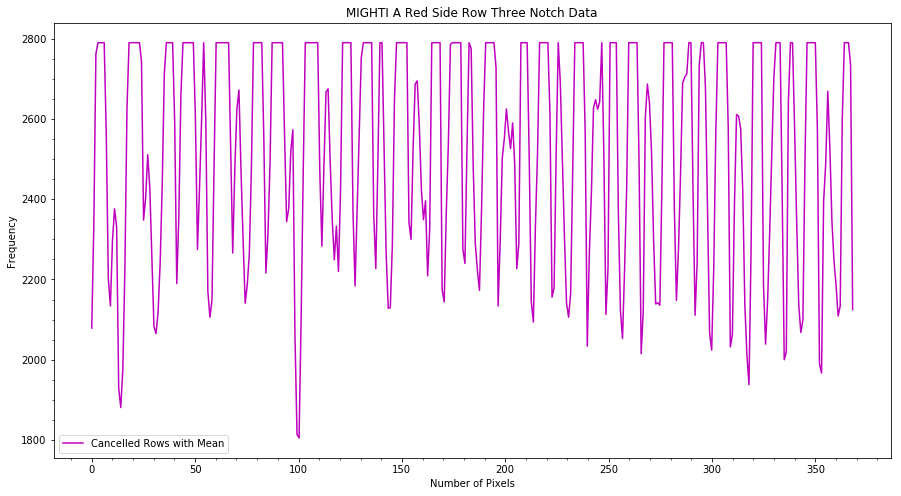

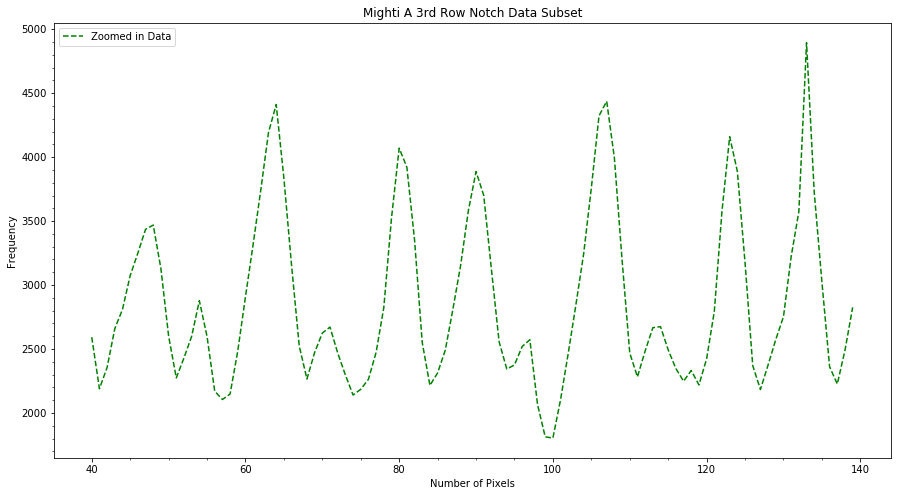

In [5]:
data = pd.read_csv(r'C:\Users\athayer\Desktop\NRL Python Files\realdata.txt', header = 0)
rdata = np.transpose(data.values)

noNotch = rdata[10][32:400]
bNotch =  rdata[2][32:400]

testfit = Comparison(noNotch, bNotch, 0.05, 1.1)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 8)
x = np.arange(40, 140)
ax.plot(x, bNotch[40:140], 'g--', label = 'Zoomed in Data')
ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Mighti A 3rd Row Notch Data Subset')

In [6]:
x = np.linspace(0, np.size(bNotch), np.size(bNotch))
sigma = 1 #This value is 1 for now to see just square distance for chisq



#Now to check all of the noise removal to see if they made the data more like a square wave




#First try nofit to know if the fits actually got closer or it was close already
NoFit = paramfitcheck(x, testfit[0], sigma)

#Now try the other fits-- LP did not converge
MeanFit = paramfitcheck(x, testfit[1], sigma)
#LowPassFit = paramfitcheck(x, testfit[2], sigma)
SmoothFit = paramfitcheck(x, testfit[3], sigma)
NegFit = paramfitcheck(x, testfit[4], sigma)
NegandAttFit = paramfitcheck(x, testfit[5], sigma)

Fit Performed:
    a1 = -0.5293086551593171 +/- 0.7023980745546777
    a2 = 1.4066910733108384 +/- 1.1656948992788239
    a3 = 2.7210666769276304 +/- 2.0524462506609438
    a4 = 6.197629306655079 +/- 4.522429179819483       
    a5 = 2790.3754332334315 +/- 34.167987831735054
    a6 = 86.12113169878485 +/- 46.03185989565801
    chisq = 2192.932512724866
    normchisq = 6.057824620786922
    dof = 362
    goodness of fit = 6.091420317382447e-259
Fit Performed:
    a1 = 0.1773404885344859 +/- 0.10688923881345165
    a2 = 5.761119231402767 +/- 1.7568521286332142
    a3 = 3.9770223999729133 +/- 1.1970046653409714
    a4 = 5.904794379882961 +/- 1.7952456282442613       
    a5 = 2522.597619122519 +/- 14.26846212409363
    a6 = 35.96304595165704 +/- 7.22871949480292
    chisq = 249.17284173587538
    normchisq = 0.6883227672261751
    dof = 362
    goodness of fit = 0.9999987315347539
Fit Performed:
    a1 = 0.41254708376169785 +/- 0.4795843775927234
    a2 = 4.294486437137511 +/- 2.543373327

Most Contributing Frequencies: [ 0.04619565  0.07065217  0.11684783]
Fit Performed:
    a1 = -0.5452670593689832 +/- 1.3974570676580704
    a2 = 2.7785825083772138 +/- 3.8346623363273507
    a3 = 4.088694732600174 +/- 5.502708845582183
    a4 = 5.747290901824597 +/- 7.6447221513772075       
    a5 = 1525.7117459228598 +/- 62.02035488333076
    a6 = 68.56868417743654 +/- 93.7195058768431
    chisq = 14454.667856100943
    normchisq = 39.930021701936305
    dof = 362
    goodness of fit = 0.0
Fit Performed:
    a1 = -0.16264704100681643 +/- 0.19988192655377696
    a2 = 2.1773127278601545 +/- 1.4019313933890964
    a3 = 3.637164989632815 +/- 2.335766156401935
    a4 = 6.1427486563120945 +/- 3.928258018940452       
    a5 = 981.1162641364796 +/- 30.25922939910131
    a6 = 94.04329788273262 +/- 13.65865638328583
    chisq = 8144.730096974725
    normchisq = 22.499254411532387
    dof = 362
    goodness of fit = 0.0
Fit Performed:
    a1 = 3.060829239137414 +/- 6.607009998726419
    a2 = 6

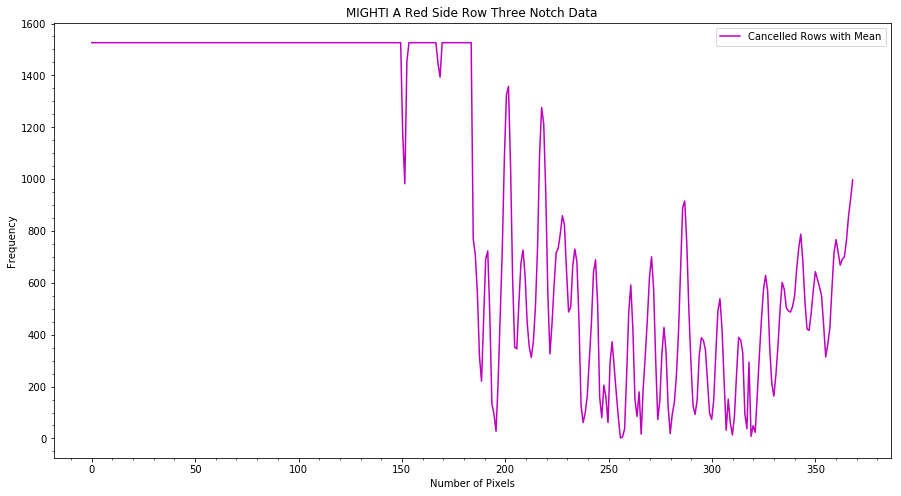

In [7]:
#Going to try FFT and removing dominant frequencies then getting ride of noise after that
#This might allow the notches to be perceived less as noise

DomFreqFinder(bNotch, 0.8e10)
N= np.size(bNotch)
Notchft = np.fft.fft(bNotch, n = 2*N) #I used zero padding here, I think it adds zeroes at both ends
nf = Freqmaker(bNotch)

#I had to find the dominant frequencies by hand and remove by looking at data, this could be automated 
#Probably dominant frequency +- 1-2% 

for i in range(np.size(Notchft) -1):
    if ((Notchft[i] > .1 and Notchft[i]) < .12 or (Notchft[i] > .03 and Notchft[i] < .05)):
        Notchft[i] = 0

#After removing the noise I inversed the fft 
Notchv2 = np.abs(np.fft.ifft(Notchft)) 
#Had to manually remove zeroes though
Notchv2 = Notchv2[N//2:3 * N//2]

#Get all noise removal again 
testfit2 = Comparison(noNotch, Notchv2, 0.048, 1)


#Now to compare noise removal back to fft. Maybe should compare to original as well.

#Note: These all have horrible Q and the graph looks weird. ask about 
FourierFit = paramfitcheck(x, testfit2[0], sigma)


FourierFitMean = paramfitcheck(x, testfit2[1], sigma)
FourierFitLowPass = paramfitcheck(x, testfit2[2], sigma)
FourierFitSmooth = paramfitcheck(x, testfit2[3], sigma)

Fit Performed:
    a1 = -0.5293086551593171 +/- 0.7023980745546777
    a2 = 1.4066910733108384 +/- 1.1656948992788239
    a3 = 2.7210666769276304 +/- 2.0524462506609438
    a4 = 6.197629306655079 +/- 4.522429179819483       
    a5 = 2790.3754332334315 +/- 34.167987831735054
    a6 = 86.12113169878485 +/- 46.03185989565801
    chisq = 2192.932512724866
    normchisq = 6.057824620786922
    dof = 362
    goodness of fit = 6.091420317382447e-259
Fit Performed:
    a1 = 1.8453914844261856 +/- 3.005596148671932
    a2 = -3.732541238729449 +/- 4.235830264894943
    a3 = 6.044820734879809 +/- 6.067373341052288
    a4 = 7.872021179463417 +/- 7.656172116480076       
    a5 = 1951.9168956477267 +/- 43.315376614259
    a6 = -51.452247458232726 +/- 190.97539274935627
    chisq = 25.769863794750133
    normchisq = 0.07118746904627109
    dof = 362
    goodness of fit = 1.0


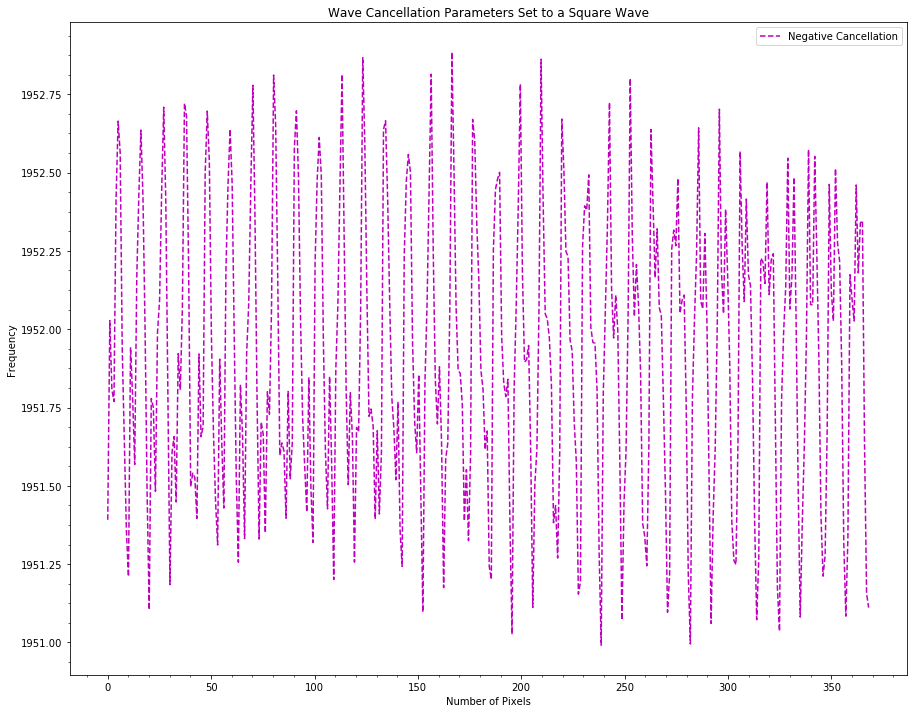

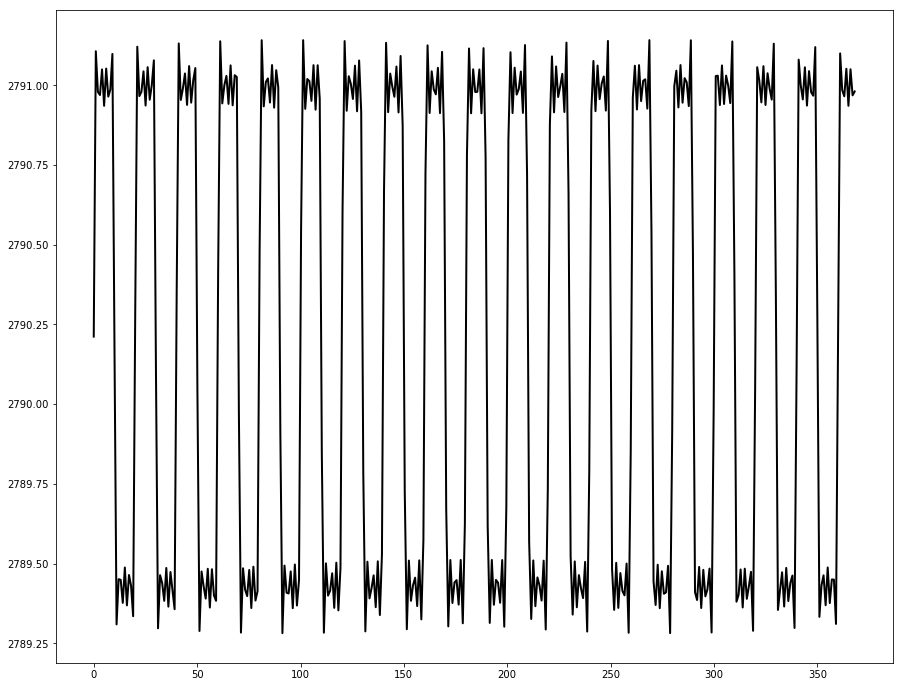

In [9]:
#This is not a pretty way of doing this but I am checking the parameters passed back into the sqaure wave
# and graphing the results against an optimal square wave for a visual confirmation

NoFitData = squarewave(x, NoFit[0][0],  NoFit[0][1],  NoFit[0][2],  NoFit[0][3],  NoFit[0][4],  NoFit[0][5])
MeanFitData = squarewave(x, MeanFit[0][0],  MeanFit[0][1],  MeanFit[0][2],  MeanFit[0][3],  MeanFit[0][4], MeanFit[0][5])
#LowFitData = squarewave(x, LowPassFit[0][0],  LowPassFit[0][1],  LowPassFit[0][2],  LowPassFit[0][3],  LowPassFit[0][4], LowPassFit[0][5])
SmoothFitData = squarewave(x, SmoothFit[0][0],  SmoothFit[0][1],  SmoothFit[0][2],  SmoothFit[0][3],  SmoothFit[0][4], SmoothFit[0][5])
NegFitData = squarewave(x, NegFit[0][0],  NegFit[0][1],  NegFit[0][2],  NegFit[0][3],  NegFit[0][4], NegFit[0][5])
NegandMeanData = squarewave(x, NegFit[0][0],  NegandAttFit[0][1],  NegandAttFit[0][2],  NegandAttFit[0][3],  NegandAttFit[0][4], NegandAttFit[0][5])

FourierData = squarewave(x, FourierFit[0][0],  FourierFit[0][1],  FourierFit[0][2],  FourierFit[0][3],  FourierFit[0][4], FourierFit[0][5])
FourierMeanData = squarewave(x, FourierFitMean[0][0],  FourierFitMean[0][1],  FourierFitMean[0][2],  FourierFitMean[0][3],  FourierFitMean[0][4], FourierFitMean[0][5])
FourierLPData = squarewave(x, FourierFitLowPass[0][0],  FourierFitLowPass[0][1],  FourierFitLowPass[0][2],  FourierFitLowPass[0][3],  FourierFitLowPass[0][4], FourierFitLowPass[0][5])
FourierSmoothData = squarewave(x, FourierFitSmooth[0][0],  FourierFitSmooth[0][1],  FourierFitSmooth[0][2],  FourierFitSmooth[0][3],  FourierFitSmooth[0][4], FourierFitSmooth[0][5])



fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 12)
x = np.linspace(0, np.size(bNotch), np.size(bNotch))
ax.plot(x, NegFitData, 'm--', label = 'Negative Cancellation')
newx = x[::5]
nMeanFitData = MeanFitData[::5]

#ax.plot(x, NoFitData, 'g--', label = 'Original')



#ax.plot(x, SmoothFitData, 'c--', label = 'Smooth')
###ax.plot(x, LowFitData, 'k--', label = 'Low Pass')


#ax.plot(x, FourierData, 'g--', label = 'Fourier')
#ax.plot(x, FourierMeanData, 'r--', label = 'Fourier + Mean')
#ax.plot(x, FourierLPData, 'k--', label = 'Fourier + Lowpass')
#ax.plot(x, FourierSmoothData, 'c--', label = 'Fourier + Smooth')

ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Wave Cancellation Parameters Set to a Square Wave')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.set_size_inches(15, 12)
smallx = np.linspace(0, 5, 5)
ax2.plot(x, squarewave(x, 1, 3, 5, 7, np.mean(bNotch), 0), 'k-', lw = 2, label = 'Square Wave')


NoFit = paramfitcheck(x, testfit[0], sigma)
NegFit = paramfitcheck(x, testfit[4], sigma)

Fit Performed:
    a1 = -0.5293086551593171 +/- 0.7023980745546777
    a2 = 1.4066910733108384 +/- 1.1656948992788239
    a3 = 2.7210666769276304 +/- 2.0524462506609438
    a4 = 6.197629306655079 +/- 4.522429179819483       
    a5 = 2790.3754332334315 +/- 34.167987831735054
    a6 = 86.12113169878485 +/- 46.03185989565801
    chisq = 2192.932512724866
    normchisq = 6.057824620786922
    dof = 362
    goodness of fit = 6.091420317382447e-259
Fit Performed:
    a1 = 0.1773404885344859 +/- 0.10688923881345165
    a2 = 5.761119231402767 +/- 1.7568521286332142
    a3 = 3.9770223999729133 +/- 1.1970046653409714
    a4 = 5.904794379882961 +/- 1.7952456282442613       
    a5 = 2522.597619122519 +/- 14.26846212409363
    a6 = 35.96304595165704 +/- 7.22871949480292
    chisq = 249.17284173587538
    normchisq = 0.6883227672261751
    dof = 362
    goodness of fit = 0.9999987315347539


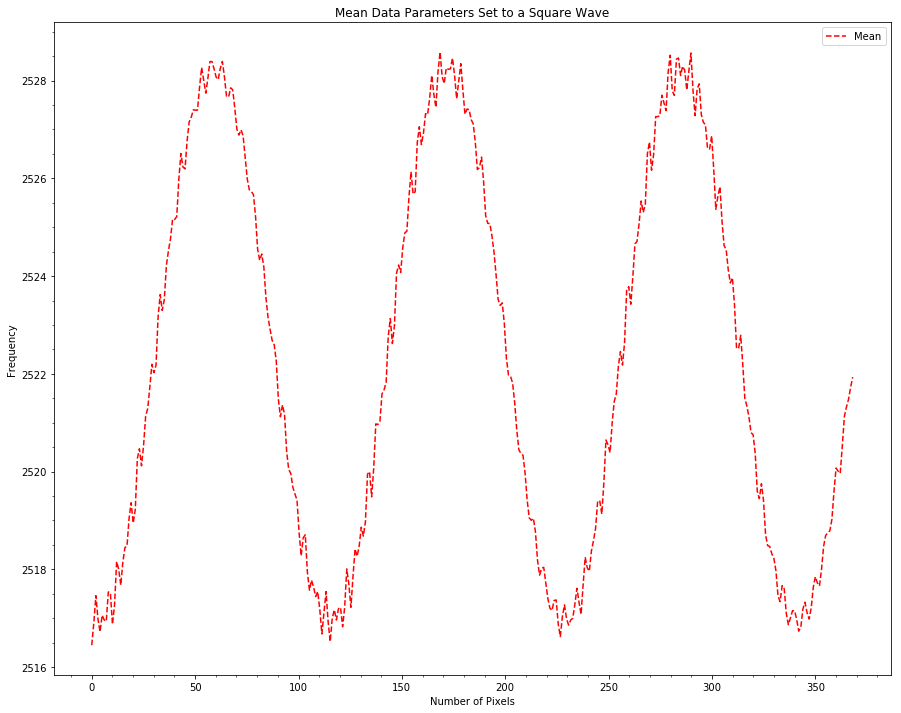

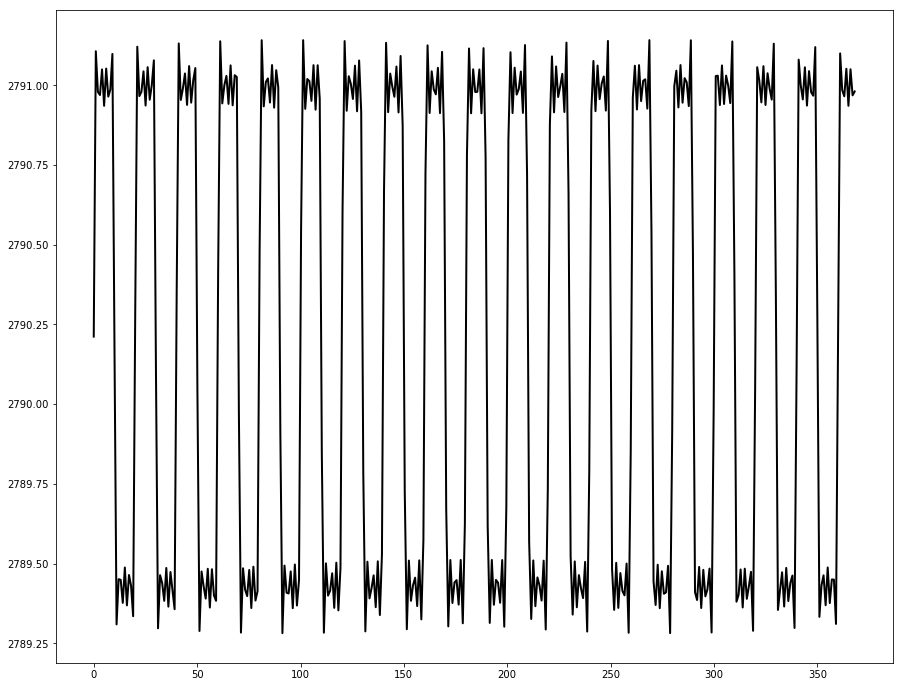

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 12)
ax.plot(x, MeanFitData, 'r--', label = 'Mean')

ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Mean Data Parameters Set to a Square Wave')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.set_size_inches(15, 12)
ax2.plot(x, squarewave(x, 1, 3, 5, 7, np.mean(bNotch), 0), 'k-', lw = 2, label = 'Square Wave')

NoFit = paramfitcheck(x, testfit[0], sigma)
MeanFit = paramfitcheck(x, testfit[1], sigma)

Fit Performed:
    a1 = 0.1773404885344859 +/- 0.10688923881345165
    a2 = 5.761119231402767 +/- 1.7568521286332142
    a3 = 3.9770223999729133 +/- 1.1970046653409714
    a4 = 5.904794379882961 +/- 1.7952456282442613       
    a5 = 2522.597619122519 +/- 14.26846212409363
    a6 = 35.96304595165704 +/- 7.22871949480292
    chisq = 249.17284173587538
    normchisq = 0.6883227672261751
    dof = 362
    goodness of fit = 0.9999987315347539


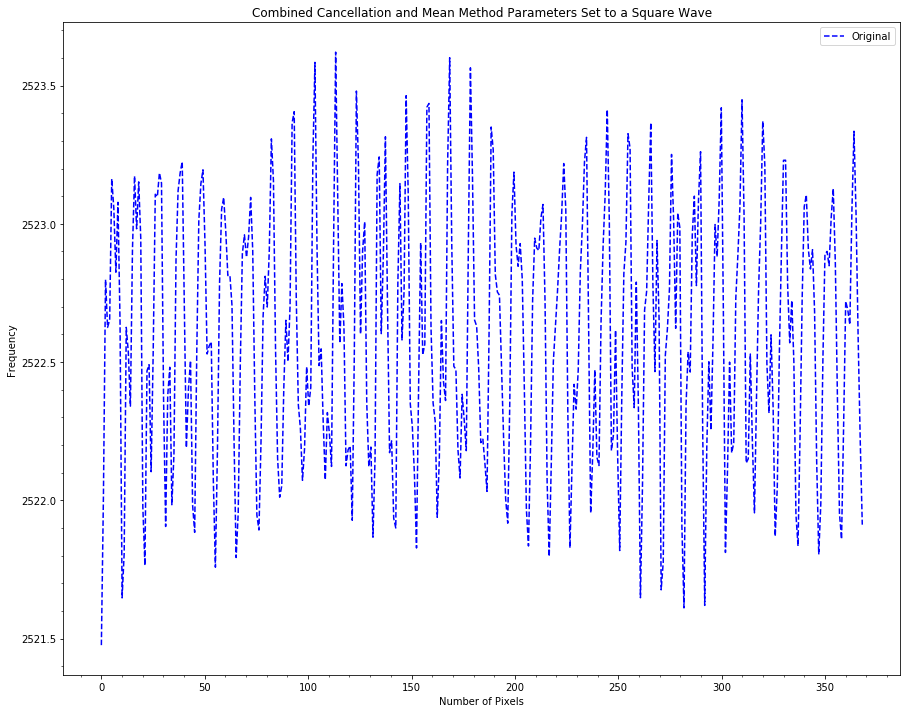

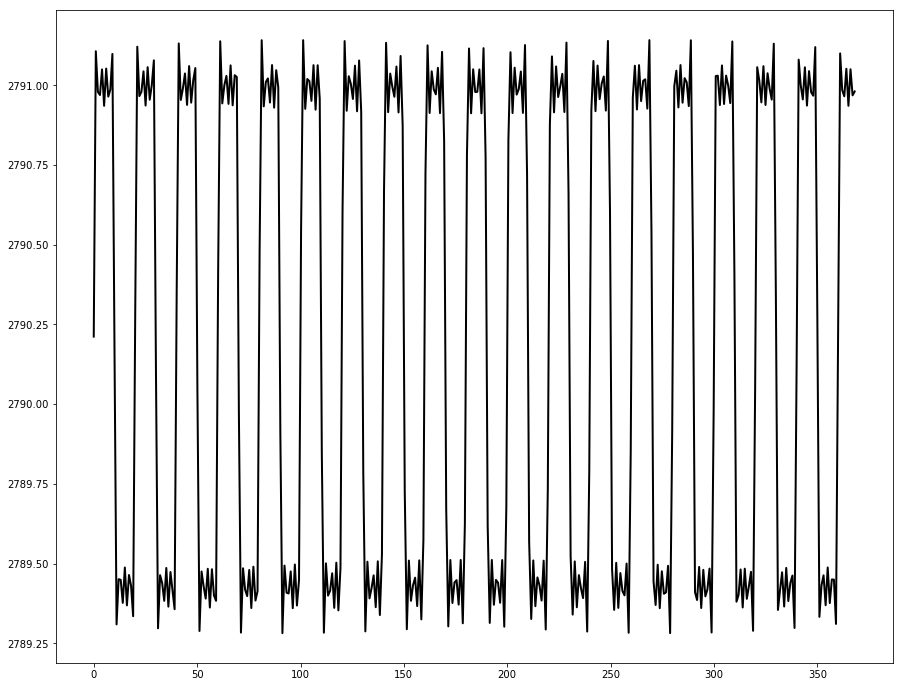

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 12)
x = np.linspace(0, np.size(bNotch), np.size(bNotch))
ax.plot(x, NegandMeanData, 'b--', label = 'Original')

ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Combined Cancellation and Mean Method Parameters Set to a Square Wave')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.set_size_inches(15, 12)
smallx = np.linspace(0, 5, 5)
ax2.plot(x, squarewave(x, 1, 3, 5, 7, np.mean(bNotch), 0), 'k-', lw = 2, label = 'Square Wave')

NegandAttFit = paramfitcheck(x, testfit[5], sigma)

Fit Performed:
    a1 = -0.5293086551593171 +/- 0.7023980745546777
    a2 = 1.4066910733108384 +/- 1.1656948992788239
    a3 = 2.7210666769276304 +/- 2.0524462506609438
    a4 = 6.197629306655079 +/- 4.522429179819483       
    a5 = 2790.3754332334315 +/- 34.167987831735054
    a6 = 86.12113169878485 +/- 46.03185989565801
    chisq = 2192.932512724866
    normchisq = 6.057824620786922
    dof = 362
    goodness of fit = 6.091420317382447e-259


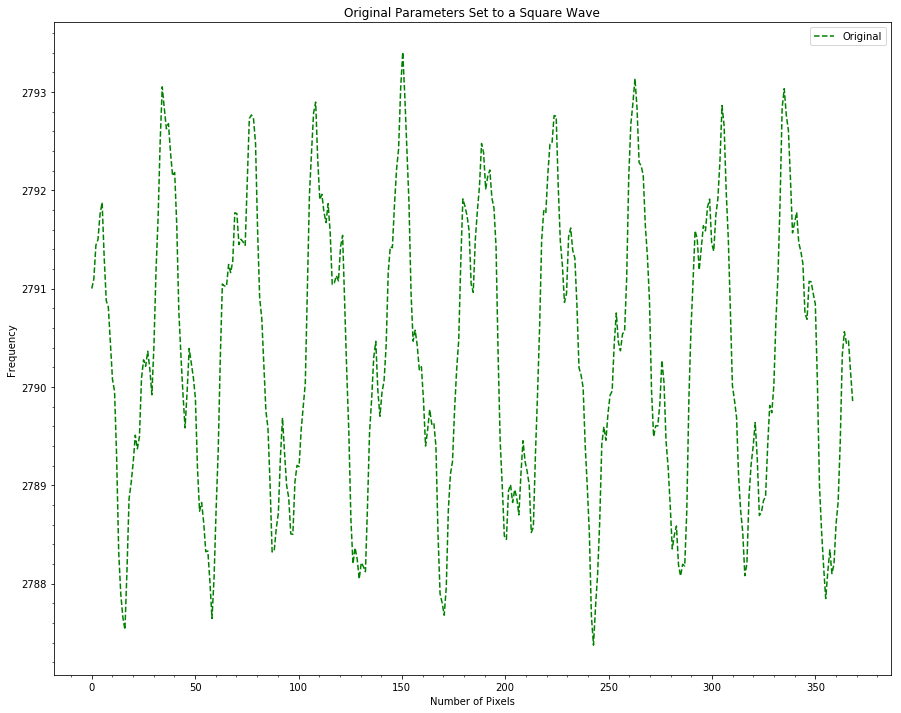

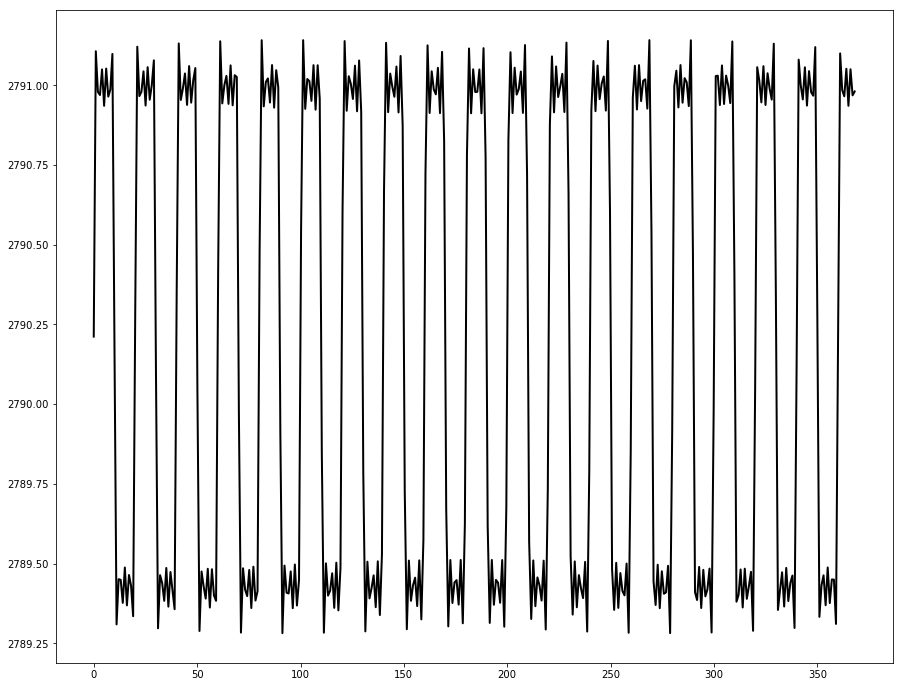

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 12)
x = np.linspace(0, np.size(bNotch), np.size(bNotch))
ax.plot(x, NoFitData, 'g--', label = 'Original')

ax.legend(loc='best')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_ylabel('Frequency')
ax.set_title('Original Parameters Set to a Square Wave')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.set_size_inches(15, 12)
smallx = np.linspace(0, 5, 5)
ax2.plot(x, squarewave(x, 1, 3, 5, 7, np.mean(bNotch), 0), 'k-', lw = 2, label = 'Square Wave')
NoFit = paramfitcheck(x, testfit[0], sigma)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(15, 12)
smallx = np.arange(40, 140)
smallData = MeanFitData[40:140]
ax.plot(smallx, smallData, 'r-', label = 'Mean Zoomed In')

ax.set_ylabel('Original Frequency', color= 'b')
ax2 = ax.twinx()
ax2.plot(smallx, bNotch[40:140], 'b-', label = 'Zoomed in Data')
ax2.set_ylabel('Mean Frequency', color = 'r')

ax.plot(smallx, NegFitData[40:140] + 570, 'm-.', label = 'Negative Zoomed In')

ax.legend(loc='best')
ax2.legend(loc='upper left')
ax.minorticks_on()
ax.set_xlabel('Number of Pixels')
ax.set_title('Comparing Orginal Data to Result ')




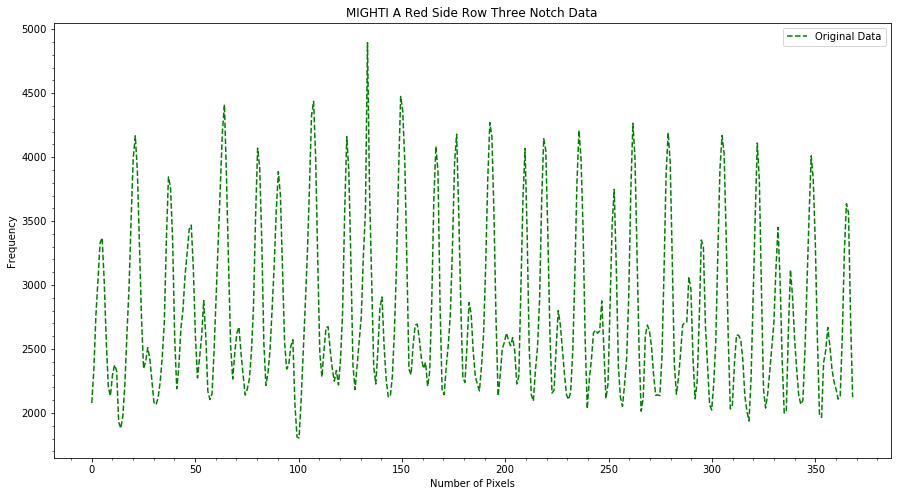

In [22]:
testfit3 = Comparison(noNotch, bNotch, 0.05, 1.1)
Original = testfit[0] 
Mean = testfit[1]
Lowpass = testfit[2]
Smooth = testfit[3] 
Negative = testfit[4] 
NegativeMean = testfit[5]

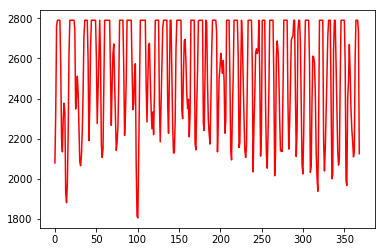

In [30]:
plt.plot(x, Mean, 'r-', ms = 3, label = 'Mean Collection')

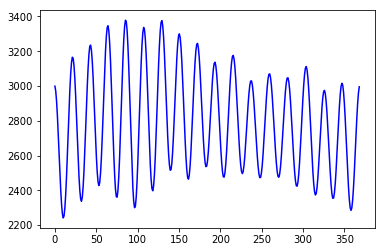

In [31]:
plt.plot(x, Lowpass, 'b-', lw = 1.5, label = 'Lowpass')

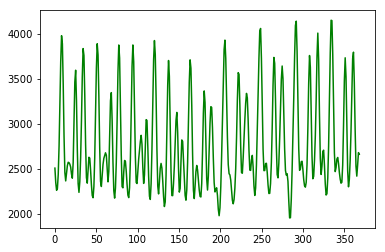

In [32]:
plt.plot(x, Smooth, 'g-', ms = 3, label = 'Smoothing')

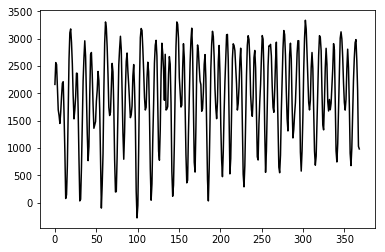

In [33]:
plt.plot(x, Negative, 'k-', ms = 3, label = 'Cancelled Rows')

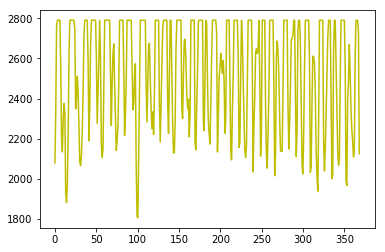

In [34]:
plt.plot(x, NegativeMean, 'y-', ms = 3, label = 'Cancelled Rows with Mean')